# IMAGE DATA PROCESSING OR GENERATION, IN GENERAL
- [Classification resources](https://www.uspto.gov/web/patents/classification/cpc/html/cpc-G06T.html)
- [Data](https://gerdes.fr/saclay/informationRetrieval/patentFiles/G06T.txt.gz)

## 🪐 Authors
- Dana AUBAKIROVA
- Benedicutus Kent RACHMAT


### 0. IMPORTS

Uncomment this line if you don't have the text file 

In [1]:
# %%bash
# python -m spacy download en_core_web_lg
# pip install trankit
# wget https://gerdes.fr/saclay/informationRetrieval/patentFiles/G06T.txt.gz -P texts
# gzip -d G06T.txt.gz

In [2]:
import spacy
from spacy.tokens import Span
from spacy.tokens import DocBin
from spacy import displacy
from spacy.util import filter_spans
from spacy.matcher import PhraseMatcher
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from trankit import Pipeline
from lib import *

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
FUNKY_COLOR = "linear-gradient(90deg, #aa9cfc, #fc9ce7)"

### I. EXPLORATORY ANALYSIS

In [4]:
g06t = open('texts/G06T.txt').read().strip()
patent_texts = g06t.split('\n\n')
patent_lines = g06t.split('\n')

# potential terms
many_terms = open('texts/manyterms.lower.txt').read().lower().strip().split('\n')
print("manyterms.lower.txt contains", len(many_terms), 'terms')


print(len(patent_lines), 'paragraphs of patent text')

# large english pre-trained language model
nlp = spacy.load("en_core_web_lg")
shorttext = patent_texts[0][18000:20000]
doc = nlp(shorttext)
displacy.render(doc, style="ent", jupyter=True)


manyterms.lower.txt contains 743274 terms
298995 paragraphs of patent text


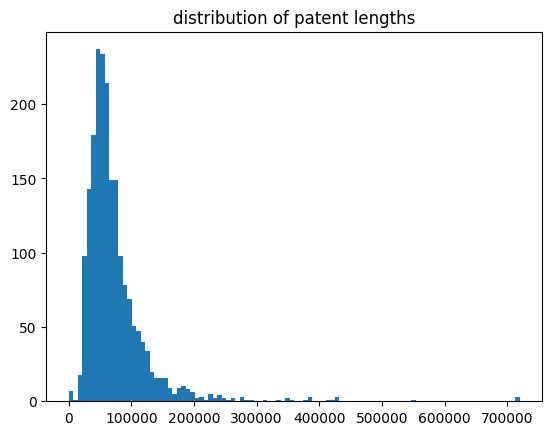

In [5]:
# distribution of patent lengths
patent_lengths = [len(p) for p in patent_texts]
plt.hist(patent_lengths, bins=100)
plt.title("distribution of patent lengths")
plt.show()

Removing the References numbers and the determiners from the text.

In [6]:
num2termlist = rawExtractRefs(shorttext)
print("References numbers and terms:")
display(num2termlist)

References numbers and terms:


{400: ['method'],
 401: ['begins at step'],
 102: ['background data stream'],
 402: ['step'],
 101: ['foreground data stream'],
 403: ['step'],
 404: ['step'],
 100: ['high bit rate stream'],
 406: ['step']}

In [7]:
remove_list = ['r']
exclude_list = ['FIG', 'FIGS']
cleanNshort = removeNumbers(shorttext, num2termlist)
doc = nlp(cleanNshort) 

noun_chunks = get_noun_chunks_v2(doc, remove_list, exclude_list)

displacy.render({'text': cleanNshort, 'ents': noun_chunks, 'title': "Improved Noun Chunks without determiners"},
                style='ent', options={'colors': {"NC": FUNKY_COLOR}}, manual=True, jupyter=True)

Adding the predicates

In [8]:
doc = nlp(cleanNshort)
displacy.render(doc, style="dep")
noun_chunks = get_noun_chunks_v2(doc, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks(doc, noun_chunks)

displacy.render({'text': cleanNshort, 'ents': noun_chunks + predicates,
                'title': None}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": FUNKY_COLOR}})

#### Semantic Graph Representation 

inspired by [Knowledge-Graph-Spacy](https://www.kaggle.com/code/cananserper/knowledge-graph-spacy) 

In [9]:
df = pd.DataFrame({'source': [str(s) for s in sources], 'target': [str(t) for t in targets], 'edge': [r['text'] for r in predicates]})
df.head(10)

,source,target,edge
0,method,variation,is
1,variation,widely known MPEG-DASH standard,of
2,available streams,previous embodiments,to
3,method,step,at
4,step,reception,with
5,reception,subsequent presentation,for
6,subsequent presentation,background data stream,of
7,background data stream,information,on
8,information,information data,present in blending
9,information data,other information,on


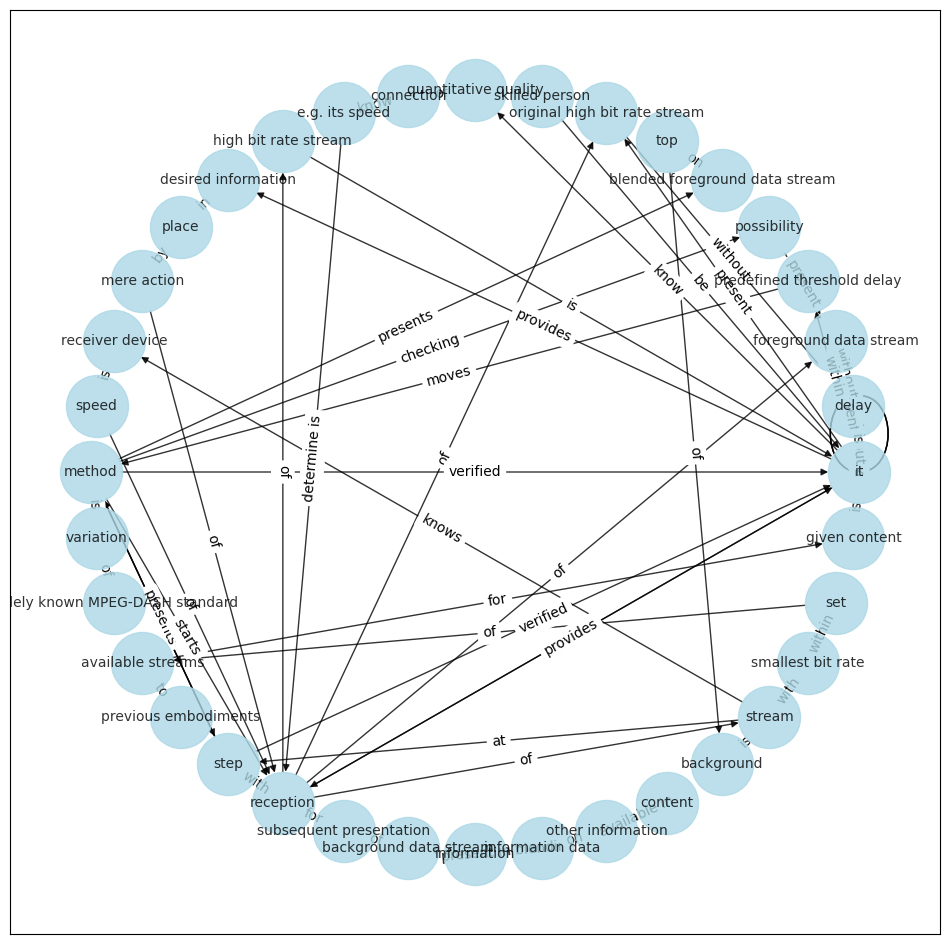

In [10]:
G = nx.from_pandas_edgelist(df, "source", "target",
                            edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12, 12))

pos = nx.shell_layout(G)
nx.draw_networkx(G, with_labels=True, pos=pos, node_size=2000, node_color='lightblue', edge_color='black', width=1, alpha=0.8, font_size=10)

edge_labels = {(row['source'], row['target']): row['edge']
               for _, row in df.iterrows()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()



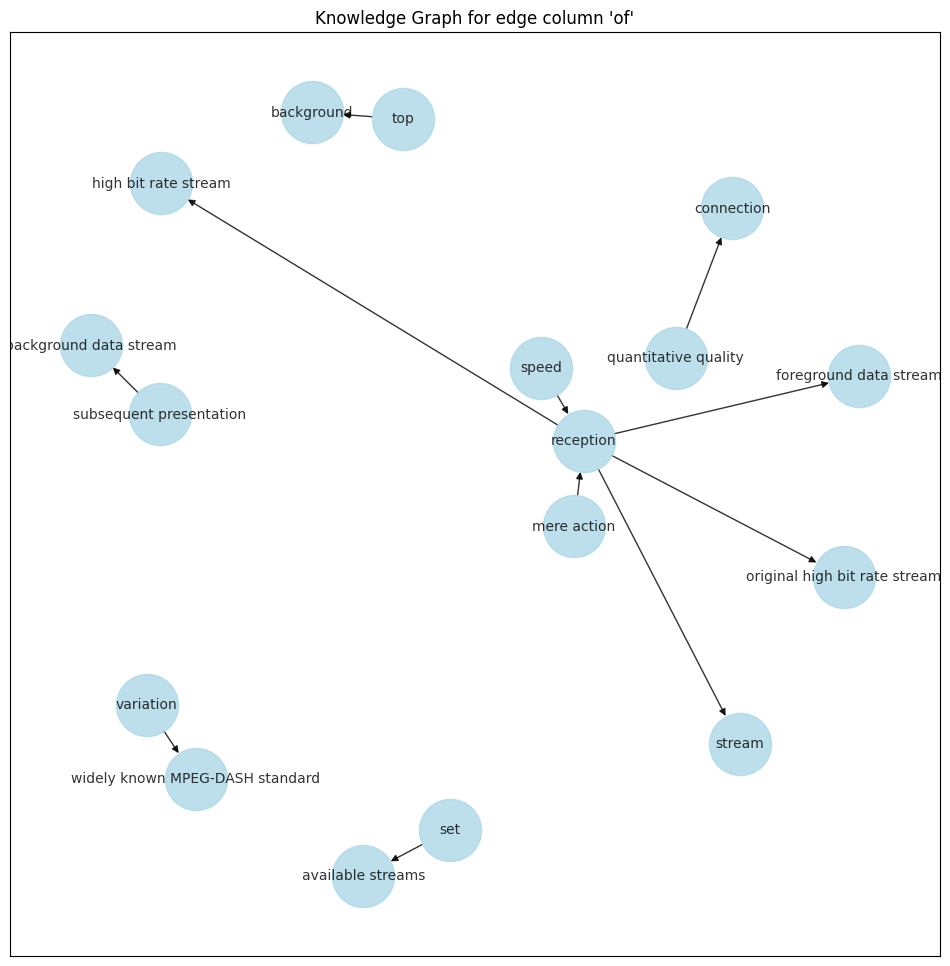

In [11]:
G=nx.from_pandas_edgelist(df[df['edge']=="of"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw_networkx(G, with_labels=True, pos=pos, node_size=2000, node_color='lightblue', edge_color='black', width=1, alpha=0.8, font_size=10)
plt.title("Knowledge Graph for edge column 'of'")
plt.show()

In [12]:
# # do we need to apply for the whole text?
# num2termlist_whole = rawExtractRefs(g06t)
# print("References numbers and terms:")
# display(num2termlist_whole)

###  II. Spacy

#### ideas
- make a matrix of relations between all NC in a sentence and choose the best ones
- handle coordinations
- ternary relations work?
- better parser: Trankit?
- text preparation to improve results
	- "said"
	- past participles into "that is pp" (no past tense in patents?)
- coreference resolution
- negation
- special treatment for non-connected graphs
- nice inline visualization

In [13]:
cvectorizer = CountVectorizer(ngram_range=(1, 3), stop_words='english', vocabulary=many_terms, min_df=500)
X = cvectorizer.fit_transform(patent_lines)
Xdf = pd.DataFrame(np.sum(X, axis=0), columns=cvectorizer.get_feature_names_out()).T.sort_values(by=0, ascending = False)
Xdf.columns = ['count']
Xdf.head(10)

,count
image processing,20995
electronic device,11964
control unit,9676
point cloud,8326
information processing,8074
display device,7039
computer readable,6499
user interface,6342
image sensor,5967
light source,5164


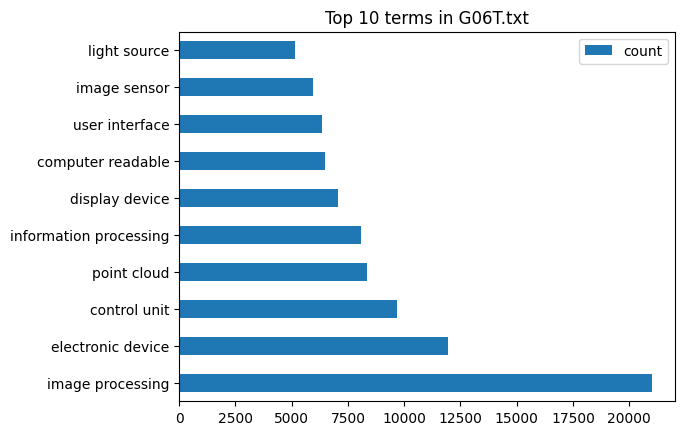

In [14]:
top_10 = Xdf.head(10)
top_10.plot.barh()
plt.title("Top 10 terms in G06T.txt")
plt.show()

In [15]:
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
patterns = [nlp.make_doc(text) for text in Xdf.index]
matcher.add("Tech", patterns)

In [16]:
train_lines, test_lines = train_test_split(patent_lines, test_size=0.3, random_state=42)

In [17]:
def create_dataset(text, n_lines, filename, offset=0):
    LABEL = "TECH"
    doc_bin = DocBin()   
    nlp = spacy.blank("en") if (filename == "test_data.spacy") or (filename == "valid_data.spacy") else spacy.load("en_core_web_lg")
    
    for training_example in tqdm(text[offset:offset+n_lines]):
        doc = nlp.make_doc(training_example)
        ents = []

        for match_id, start, end in matcher(doc):
            span = Span(doc, start, end, label=LABEL)
            if span is None:
                print("Skipping entity")
            else:
                ents.append(span)

        filtered_ents = filter_spans(ents)
        doc.ents = filtered_ents
        doc_bin.add(doc)

    print("- Saving", len(doc_bin), "documents to", filename)
    doc_bin.to_disk(filename)

In [18]:
create_dataset(train_lines, 45000, "training_data.spacy")
create_dataset(train_lines, 10000, "valid_data.spacy", 45000)
create_dataset(test_lines, 10000, "test_data.spacy")

  0%|          | 0/45000 [00:00<?, ?it/s]

- Saving 45000 documents to training_data.spacy


  0%|          | 0/10000 [00:00<?, ?it/s]

- Saving 10000 documents to valid_data.spacy


  0%|          | 0/10000 [00:00<?, ?it/s]

- Saving 10000 documents to test_data.spacy


In [19]:
!python -m spacy init fill-config config/base_config.cfg config/config.cfg

✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [20]:
!python -m spacy train config/config.cfg --output ./spacy/spacy_output --paths.train ./spacy/training_data.spacy --paths.dev ./spacy/valid_data.spacy

ℹ Saving to output directory: spacy_output
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2023-04-13 10:16:43,569] [INFO] Set up nlp object from config
[2023-04-13 10:16:43,582] [INFO] Pipeline: ['tok2vec', 'ner', 'parser']
[2023-04-13 10:16:43,587] [INFO] Created vocabulary
[2023-04-13 10:16:43,588] [INFO] Finished initializing nlp object
[2023-04-13 10:18:24,183] [INFO] Initialized pipeline components: ['tok2vec', 'ner', 'parser']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner', 'parser']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  LOSS PARSER  ENTS_F  ENTS_P  ENTS_R  DEP_UAS  DEP_LAS  SENTS_F  SCORE 
---  ------  ------------  --------  -----------  ------  ------  ------  -------  -------  -------  ------
  0       0          0.00     62.83         0.00    4.32    2.40   21.25     0.00     0.00   100.00    0.02
  0     200        119.

In [21]:
nlp_ner = spacy.load("./spacy/spacy_output/model-best")
doc = nlp_ner(shorttext)
spacy.displacy.render(doc, style="ent", jupyter=True)

In [ ]:
p = Pipeline(lang='english', gpu=False, cache_dir='./cache')

untokenized_doc = '''Hello! This is Trankit.'''
pretokenized_doc = [['Hello', '!'], ['This', 'is', 'Trankit', '.']]

processed_doc1 = p(untokenized_doc)
processed_doc2 = p(pretokenized_doc)

untokenized_sent = '''This is Trankit.'''
pretokenized_sent = ['This', 'is', 'Trankit', '.']

processed_sent1 = p(untokenized_sent, is_sent=True)
processed_sent2 = p(pretokenized_sent, is_sent=True)

### III. Prodigy

goal
- train spacy models for the extraction of relations
- find alternative
- compare

https://support.prodi.gy/t/beta-testers-wanted-new-manual-dependencies-relations-ui-v1-10/2893

In [70]:
!prodigy


============================ ✨  Available recipes ============================

dep.teach, dep.correct

compare, mark, match, print-dataset, print-stream, review, spacy-config, train,
train-curve, data-to-spacy, stats, drop, db-in, db-out, db-merge, progress

ner.teach, ner.manual, ner.correct, ner.make-gold, ner.silver-to-gold,
ner.eval-ab

textcat.teach, textcat.manual, textcat.correct

pos.teach, pos.correct, pos.make-gold

sent.teach, sent.correct

terms.teach, terms.to-patterns

image.manual

rel.manual

coref.manual

audio.manual, audio.transcribe

spans.manual, spans.correct


In [20]:
!prodigy ner.teach ner_tech  spacy/spacy_output/model-best  texts/G06T.txt --label TECH --patterns patterns.jsonl --exclude patterns_exclude.jsonl 

Using 1 label(s): TT
ℹ Available labels in model spacy_output/model-best: ['TECH']

✘ Can't find label 'TT' in model spacy_output/model-best
ner.teach will only show entities with one of the specified labels. If a label
is not available in the model, Prodigy won't be able to propose entities for
annotation. To add a new label, you can specify a patterns file containing
examples of the new entity as the --patterns argument or pre-train your model
with examples of the new entity and load it back in.



In [ ]:
!prodigy ner.correct gold_tech  ./spacy/spacy_output/model-best  G06T.txt --label TECH_M

In [ ]:
!prodigy ner.silver-to-gold gold_tech ner_tech ./spacy/spacy_output/model-best --label TECH_M 

In [ ]:
!prodigy data-to-spacy ./spacy/prodigy_output --ner gold_tech --eval-split 0.3

In [ ]:
!prodigy train ./spacy/prodigy_output --ner gold_tech --eval-split 0.3 --base-model ./spacy/spacy_output/model-best 

In [71]:
!prodigy stats ner_tech #--label TECH_M


============================== ✨  Prodigy Stats ==============================

Version          1.11.8                        
Location         /usr/local/anaconda3/lib/python3.9/site-packages/prodigy
Prodigy Home     /Users/kentrachmat/.prodigy   
Platform         macOS-10.16-x86_64-i386-64bit 
Python Version   3.9.13                        
Database Name    SQLite                        
Database Id      sqlite                        
Total Datasets   2                             
Total Sessions   14                            


============================== ✨  Dataset Stats ==============================

Dataset       ner_tech           
Created       2023-04-07 06:55:48
Description   None               
Author        None               
Annotations   75                 
Accept        64                 
Reject        8                  
Ignore        3                  



In [ ]:
nlp_ner = spacy.load("./spacy/prodigy_output/model-best")

colors = {"TECH": "#7DF6D9", "TECH_M": "#7DF6D9"}
options = {"colors": colors} 

for line in test_lines[10000:10010]:
    doc = nlp_ner(line)
    spacy.displacy.render(doc, style="ent", options= options, jupyter=True)